In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from time import perf_counter
sns.set()

In [4]:
us_mask = pd.DataFrame(pd.read_hdf('~/Desktop/Research/data/SSF/us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []
for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = '~/Desktop/Research/data/SSF/' + name_precip
    fileloc_sst = '~/Desktop/Research/data/SSF/' + name_sst
    fileloc_hgt = '~/Desktop/Research/data/SSF/' + name_hgt
    fileloc_rhum = '~/Desktop/Research/data/SSF/' + name_rhum
    fileloc_tmp2m = '~/Desktop/Research/data/SSF/' + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index()
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index()
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index()
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index()
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index()
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
    
    hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
    rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)].tmp2m.to_numpy(),(-1,1))
    
    y_samp = y_samp.append(precip[precip['lat']==25.25].precip,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
    sst_samp = temp.sst.reset_index().sst.to_numpy()
    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size,days)).transpose() # days as rows, different locations as columns
    all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1,X_size)) #  For concatenating all data
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
X_samp = X_samp[1:]

<ipython-input-4-1eccf1caca1e>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
precip.2015.h5
precip.2016.h5
precip.2017.h5
precip.2018.h5


In [5]:
X_copy = X_samp.copy()
y_copy = y_samp.to_numpy().copy()

In [6]:
X_samp = X_copy.copy()
y_samp = y_copy.copy()
target = 'precip'

In [7]:
# This block is to switch target y from precipitation to tmp2m
y_samp = X_copy[:,X_copy.shape[1]-1].copy()
X_samp[:,X_copy.shape[1]-1] = y_copy.copy()
target = 'tmp2m'

(1812, 19)

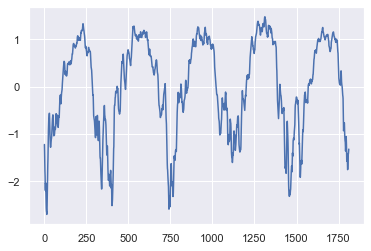

In [21]:
plt.plot(y_samp)
X.shape

In [9]:
# Calculate moving average for precip
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [10]:
# Standardize data by z-scoring
mean = np.mean(y_samp)
std = np.std(y_samp)
y_samp = (y_samp-mean)/std
X_samp[:,0:16] = (X_samp[:,0:16] - np.mean(X_samp[:,0:16]))/np.std(X_samp[:,16])
X_samp[:,16] = (X_samp[:,16] - np.mean(X_samp[:,16]))/np.std(X_samp[:,16])
X_samp[:,17] = (X_samp[:,17] - np.mean(X_samp[:,17]))/np.std(X_samp[:,17])
X_samp[:,18] = (X_samp[:,18] - np.mean(X_samp[:,18]))/np.std(X_samp[:,18])

X = X_samp.copy()
y = y_samp.copy()




In [12]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_y = torch.Tensor(y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

In [13]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [22]:
# Training parameters
BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 30

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 19 # From dataset
d_output = 1 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


In [23]:
dataloader_train = DataLoader(my_dataset,
                           batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False)

In [24]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = OZELoss(alpha=0.3)

In [25]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])

        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})

        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss

        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)

plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

[Epoch   1/30]:   0%|          | 0/1812 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

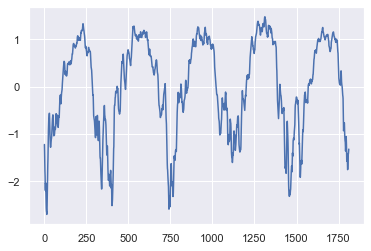

In [11]:
plt.plot(y_samp)

In [3]:
# Standardize data by taking logarithm
y_samp = y_samp.to_numpy()
y_samp = np.log(y_samp+1)
X_samp = np.log(X_samp)
X = X_samp.copy()
y = y_samp.copy()

In [51]:
def create_sequence(input_data, train_window,pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    for i in range(L-train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
        seq.append((train_seq ,train_label))
    return seq

In [52]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]


In [53]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 
train_data_array = np.concatenate((X_train,y_train),axis=1)
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [54]:
train_data.shape

torch.Size([1450, 20])

In [55]:
device = torch.device("cuda:0")
train_data = train_data.to(device)
y_train = y_train.to(device)

In [56]:
train_window = 30
pred_window = 14
train_seq = create_sequence(train_data,train_window,pred_window)

tensor(-0.4490, device='cuda:0')

In [57]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.hidden_layer_size),
                            torch.zeros(num_layers,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [58]:
model = LSTM(input_size=X_size+1, hidden_layer_size=100, num_layers=1, output_size=1).to(device) # 2 features from X_obs and 1 from y_obs
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
print(model)

LSTM(
  (lstm): LSTM(20, 20)
  (linear): Linear(in_features=20, out_features=1, bias=True)
)


In [59]:
epochs = 100
#  Training the model
t0 = perf_counter()

for i in range(epochs):
    for seq, labels in train_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                        torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))

        pred = model(seq)
        labels = torch.reshape(labels,(-1,))  #  Match size to avoid warning
        single_loss = loss_function(pred, labels)
        single_loss.backward()
        optimizer.step()
    
   
                
    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
#     print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
t1 = perf_counter()
train_time = t1 - t0
print(f'Total training time: {train_time}')

epoch:   1 loss: 0.00686995
epoch:  11 loss: 0.00255897
epoch:  21 loss: 0.04321990
epoch:  31 loss: 0.02205599
epoch:  41 loss: 0.12324524
epoch:  51 loss: 0.04761039
epoch:  61 loss: 0.00234580
epoch:  71 loss: 0.00142140
epoch:  81 loss: 0.16185334
epoch:  91 loss: 0.05098359
epoch:  99 loss: 0.0101411426
Total training time: 318.04970249999315


In [60]:
# Predicting t+1
test_data = np.concatenate((X_test,y_test),axis=1)

train_test_total = np.concatenate((train_data_array,test_data))

model.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in range(train_test_total.shape[0]-train_window):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        #print(seq)
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                            torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))
            #print(model(seq))
            pred = model(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
res = np.array(res)

In [ ]:
# Predicting t+tau
test_data = np.concatenate((X_test,y_test),axis=1) 
train_test_total = np.concatenate((train_data_array,test_data))

model.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in range(train_test_total.shape[0]-train_window):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window])
        #print(seq)
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                            torch.zeros(model.num_layers, 1, model.hidden_layer_size))
            #print(model(seq))
            pred = model(seq)
            #print(len(test_inputs))
            res.append(pred)

            

array([0.0, 0.0, 0.0, ..., tensor([0.3381], device='cuda:0'),
       tensor([0.3555], device='cuda:0'),
       tensor([0.4765], device='cuda:0')], dtype=object)

r-sq on train: 0.4734886040584132
r-sq on test: 0.5004145392377961


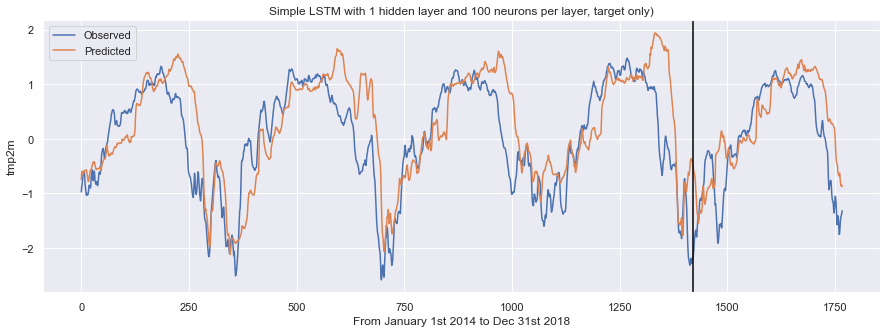

In [63]:
y_train = y_train.cpu()

print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Simple LSTM with 1 hidden layer and 100 neurons per layer, target only)')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

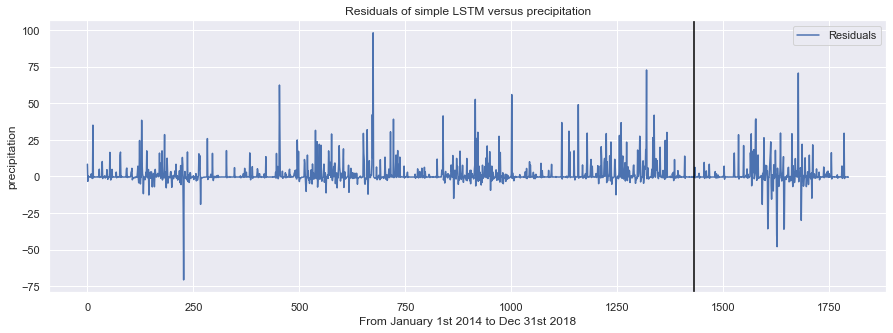

In [28]:
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window:] - res[train_window:] ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel('precipitation')
plt.title('Residuals of simple LSTM versus precipitation')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

In [54]:
np.sum((np.array(res[train_size:]) - y_test[:,0]) ** 2)/y_test.shape[0]  # MSE


tensor([0.6813], device='cuda:0')

In [429]:
tmp2m = pd.DataFrame(pd.read_hdf('SSF/tmp2m.2018.h5')).reset_index()


In [432]:
test = tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)]
test

,lat,lon,start_date,0
8108021,25.25,279.25,2018-01-01,20.244444
8108022,25.25,279.25,2018-01-02,17.381365
8108023,25.25,279.25,2018-01-03,15.314527
8108024,25.25,279.25,2018-01-04,10.294666
8108025,25.25,279.25,2018-01-05,11.791142
...,...,...,...,...
8108381,25.25,279.25,2018-12-27,24.758492
8108382,25.25,279.25,2018-12-28,25.610886
8108383,25.25,279.25,2018-12-29,24.864708
8108384,25.25,279.25,2018-12-30,23.908970


In [15]:
import pyflux as pf
test = pd.DataFrame(y_samp).astype('double')
model_VAR = pf.VAR(data=test,lags=7,integ=1)